In [2]:
import itertools
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats

LABEL_ALIAS = {
    'lit': 'In literature?',
    'ge': 'Germanosilicate composition?',
    'zeo': 'Zeolite composition?',
    'zty': 'Zeotype composition?',
}

df = pd.read_csv('../data/binding.csv', index_col=0)

In [3]:
def get_recall(df_, metric, ascending=True):
    sdf = df_.sort_values(metric, ascending=ascending)
    s = sdf[LABEL_ALIAS['lit']].cumsum() / sdf[LABEL_ALIAS['lit']].sum()
    return s

def get_norm_auc(df_, metric):
    s = get_recall(df_, metric)
    best_case = get_recall(df_, LABEL_ALIAS['lit'], ascending=False)

    return s.mean() / best_case.mean()

total cells:  112426
total cells:  112426


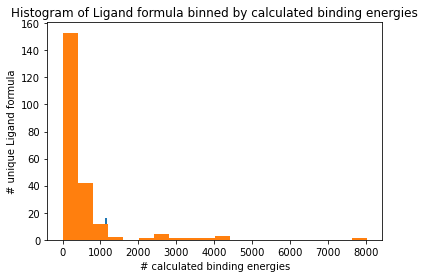

In [21]:
# idxmin = df.groupby(['Zeolite', 'InchiKey']).idxmin()
# df.iloc[0]["Competition (SiO2)"]

# pd.unique(df["Zeolite"])  # -> 209 zeolites...
# pd.unique(df["SMILES"])  # -> 1194 smiles


def construct_column_count_histogram(col: str, df: pd.DataFrame, n_bins=20):
    col_vals = pd.unique(df[col])
    histogram_by_count = {}
    for val in col_vals:
        count = len(df.loc[df[col] == val])
        histogram_by_count[count] = histogram_by_count.get(count, 0) + 1
    plt.hist(histogram_by_count, bins=n_bins)
    plt.ylabel("# unique " + col)
    plt.title("Histogram of " + col + " binned by calculated binding energies")
    plt.xlabel("# calculated binding energies")
    print(
        "total cells: ",
        sum([count * instances for count, instances in histogram_by_count.items()]),
    )

# construct_column_count_histogram("Zeolite", df)
# construct_column_count_histogram("Ligand formula", df)


In [26]:
import pdb

matrix = df.pivot(index='SMILES', columns='Zeolite', values='Binding (OSDA)')
pdb.set_trace()
print('hello')
print(matrix.notna().sum().sum()) # 17587 what gives?

matrix['AEI']['C(CC1CCNCC1)CC1CCNCC1']


--Return--
None
> <ipython-input-26-7ad42aa57e11>(4)<module>()
      2 
      3 matrix = df.pivot(index='SMILES', columns='Zeolite', values='Binding (OSDA)')
----> 4 pdb.set_trace()
      5 print('hello')
      6 print(df.isna().sum().sum()) # 17587 what gives?

*** KeyError: 'C(CC1CCNCC1)CC1CCNCC1'
-165.24856484479855
137120
*** AttributeError: 'DataFrame' object has no attribute 'isnotna'
112426


BdbQuit: 